In [24]:
%matplotlib inline

import os
import time
import math
import glob
import decimal
import datetime
import subprocess 
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from __future__ import unicode_literals
from IPython.core.display import display, HTML

In [25]:
# Load helper functions
%run plotter_fhelpers.py

In [26]:
# Global configurations
# ---------------------

# Module-specific settings
decimal.getcontext().prec = 6
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-ticks')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

# Experiment setup

Files:

```
* weak_scaling_[null|namd]_entk4/
    * [null|namd]-ws-[64|128|256|512|1024]cores-trial<int>/
        * rp.session.<string>.<string>.<int>.<int>/
            * pilot-0000/
            * rp.session.<string>.<string>.<int>.<int>.prof
        * rp.session.<string>.<string>.<int>.<int>-units-folder/
        * rp.session.<string>.<string>.<int>.<int>.prof
        * execution_profile_rp.session.<string>.<string>.<int>.<int>.csv
```

In [27]:
# Workload names and number of trials
workloads = {'null': 3, 'namd': 1}
# workloads = {'null': 3}

# List of number of total cores at various data points
cores = [64, 128, 256, 512, 1024]

# Number of cores per task
ctask = 8

# Pilot name
pname = 'pilot.0000'

# Experiment directorie
def trial_name(wrkld,ncore,ntrial):
    return '%s-ws-%scores-trial%s/' % (wrkld, ncore, ntrial)

def trial_path(wrkld,ncore,ntrial):
    base_dir = 'weak_scaling_%s_entk4/' % wrkld
    run_dir = trial_name(wrkld,ncore,ntrial)
    return base_dir+run_dir

# Dataframe Workloads

In [32]:
df_workloads = pd.DataFrame(columns=['workload','npipeline','trial','TTR','TTX','EnTKO','RPO'])
df_tasks = pd.DataFrame()

for wname in workloads.keys():
    for core in cores:
        for trial in range(1,workloads[wname]+1):
            
            try:
                sid = glob.glob('%s/rp.session.*' % trial_path(wname,core,trial))[0]
            except:
                continue
            
            # trial's number of pipelines
            t_pipeline = core/ctask
            
            # trial's name
            t_name = trial_name(wname, core, trial)[:-1]

            # trial's TTR
            t_ttr = extract_rp_tr(sid, pname)

            # trial's TTX
            if wname == 'null':
                t_ttx = 0.0
            else:
                if core == 512:
                    continue
                # extract RP Tx timestamps and NAMD Tx duration
                rp_txs = extract_rp_tx(sid)
                namd_txs = extract_namd_tx(sid, pname)
                
                # Merge NAMD Tx duration with RP Tx timestamps
                txs = rp_txs.merge(namd_txs, right_index=True,left_index=True)
                txs.columns = ['StartExecuting', 'StagingOutput', 'TxRP', 'Stage', 'TxNAMD']
                
                # Calculate the end timestamp of Tx on the base of NAMD logs
                txs['StopExecutingNAMD'] = txs['StartExecuting'] + txs['TxNAMD']
                
                # Save tasks timestamps to a dedicated DF
                df_tasks = df_tasks.append(txs, ignore_index=True)
                df_tasks['workload'] = wname
                df_tasks['npipeline'] = t_pipeline
                df_tasks['trial'] = t_name
                
                # Calculate TTX from RP unit start timestamp and the unit stop timestamp derived from NAMD
                t_ttx = extract_rp_ttx(txs[['StartExecuting','StopExecutingNAMD']].copy())
                 

            # trial's EnTK overhead
            t_path = trial_path(wname, core, trial)
            entk_csv = t_path+'enmd_pat_overhead.csv'
            t_entko = extract_entk_overhead(pd.read_csv(entk_csv, header=0, sep=',', skipinitialspace=True))

            # trial's RPO
            t_rpo = (t_ttr - t_ttx) - t_entko
            
            # store values to workload DataFrame
            df_workloads = df_workloads.append([{'workload' : wname,
                                                 'npipeline': t_pipeline,
                                                 'trial'    : t_name,
                                                 'TTR'      : t_ttr,
                                                 'TTX'      : t_ttx,
                                                 'EnTKO'    : t_entko,
                                                 'RPO'      : t_rpo}], ignore_index=True)
display(df_workloads)
display(df_tasks)

,workload,npipeline,trial,TTR,TTX,EnTKO,RPO
0,null,8,null-ws-64cores-trial1,283.5921,0.0000,0.097709,283.494391
1,null,8,null-ws-64cores-trial2,314.7924,0.0000,0.100529,314.691871
2,null,8,null-ws-64cores-trial3,330.0428,0.0000,0.104314,329.938486
3,null,16,null-ws-128cores-trial1,641.7551,0.0000,0.200379,641.554721
4,null,16,null-ws-128cores-trial2,266.1020,0.0000,0.212407,265.889593
5,null,16,null-ws-128cores-trial3,281.7811,0.0000,0.217809,281.563291
6,null,32,null-ws-256cores-trial1,869.3312,0.0000,0.437267,868.893933
7,null,32,null-ws-256cores-trial2,1893.9243,0.0000,0.386983,1893.537317
8,null,32,null-ws-256cores-trial3,576.6102,0.0000,0.448814,576.161386
9,null,64,null-ws-512cores-trial1,374.5594,0.0000,0.892151,373.667249


,Stage,StagingOutput,StartExecuting,StopExecutingNAMD,TxNAMD,TxRP,npipeline,trial,workload
0,stage_4,5330.8240,3965.9478,4521.9478,556.000,1364.8762,128,namd-ws-1024cores-trial1,namd
1,stage_4,5985.9365,4050.9809,4605.4809,554.500,1934.9556,128,namd-ws-1024cores-trial1,namd
2,stage_4,6598.7115,4740.1288,5294.0038,553.875,1858.5827,128,namd-ws-1024cores-trial1,namd
3,stage_4,7156.5063,4786.5249,5341.1499,554.625,2369.9814,128,namd-ws-1024cores-trial1,namd
4,stage_5,20172.4674,5338.8072,11979.1822,6640.375,14833.6602,128,namd-ws-1024cores-trial1,namd
5,stage_4,20710.4963,5441.5151,5996.0151,554.500,15268.9812,128,namd-ws-1024cores-trial1,namd
6,stage_5,13539.2097,5991.4721,12640.9721,6649.500,7547.7376,128,namd-ws-1024cores-trial1,namd
7,stage_4,21887.7152,6129.8853,6684.1353,554.250,15757.8299,128,namd-ws-1024cores-trial1,namd
8,stage_5,13823.7245,6604.6306,13244.6306,6640.000,7219.0939,128,namd-ws-1024cores-trial1,namd
9,stage_4,21284.8499,6847.9458,7400.8208,552.875,14436.9041,128,namd-ws-1024cores-trial1,namd


In [36]:
# Drop ourlier at 32. Clearly off-scale, it probably measured
# an execution error.
df_workloads.drop(7, inplace=True)

# Plots

In [37]:
# Calculate mean and std for RP OverHead and EnTK OverHead
# as a function of the number of pipelines
null_overheads = df_workloads[
    df_workloads.workload == 'null'][
        ['npipeline','RPO','EnTKO','TTX']].groupby(
            ['npipeline']).aggregate(
                {'RPO'  : ['mean','std'],
                 'EnTKO': ['mean','std'],
                 'TTX'  : ['mean','std']})

namd_overheads = df_workloads[
    df_workloads.workload == 'namd'][
        ['npipeline','RPO','EnTKO','TTX']].groupby(
            ['npipeline']).aggregate(
                {'RPO'  : ['mean','std'],
                 'EnTKO': ['mean','std'],
                 'TTX'  : ['mean','std']})

display(null_overheads)
display(namd_overheads)

EnTKO            TTX              RPO            
               mean       std mean  std        mean         std
npipeline                                                      
8          0.100851  0.003314  0.0  0.0  309.374916   23.674163
16         0.210198  0.008922  0.0  0.0  396.335868  212.510307
32         0.443041  0.008165  0.0  0.0  722.527660  206.993169
64         0.883182  0.016742  0.0  0.0  631.938285  246.164924
128        1.784178  0.017027  0.0  0.0  850.249356   84.699473

EnTKO             TTX               RPO    
               mean std        mean std          mean std
npipeline                                                
8          0.052571 NaN  27540.1122 NaN  11235.092329 NaN
16         0.188739 NaN  34884.5661 NaN   4464.747161 NaN
32         0.371055 NaN  37178.8081 NaN   2817.119945 NaN
128        1.754932 NaN  38478.4060 NaN   5382.634568 NaN

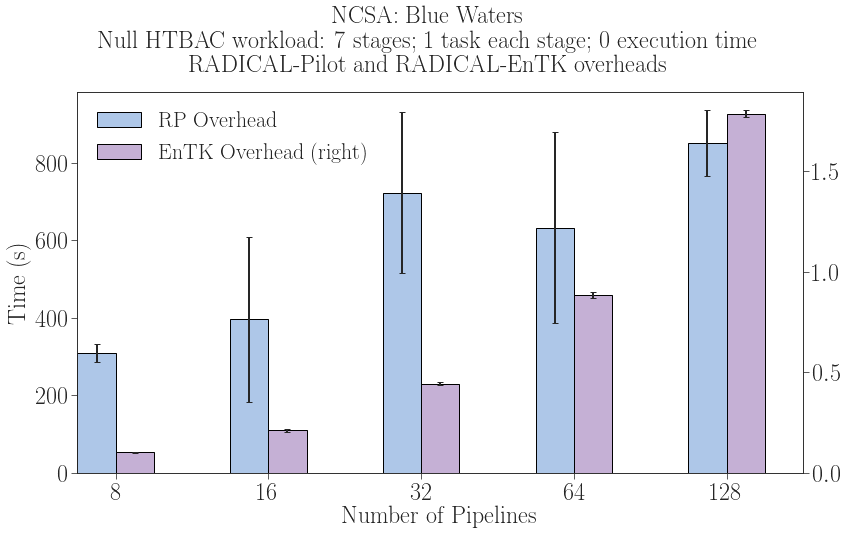

In [42]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  
    
title_head = 'NCSA: Blue Waters'
title_work = 'Null HTBAC workload: 7 stages; 1 task each stage; 0 execution time' 
title_desc = 'RADICAL-Pilot and RADICAL-EnTK overheads'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot means and std bars
null_overheads['RPO'].reset_index().plot(
    x='npipeline', 
    y='mean', 
    yerr='std',
    position=1,
    width=0.25,
    color=tableau20[1],
    ax=ax,
    rot=0,
    label='RP Overhead',
    kind='bar')

null_overheads['EnTKO'].reset_index().plot(
    x='npipeline', 
    y='mean', 
    yerr='std',
    secondary_y=True,
    position=0,
    width=0.25,
    rot=0,
    color=tableau20[9],
    ax=ax,
    label='EnTK Overhead',
    kind='bar')


ax.set_xlabel('Number of Pipelines')
ax.set_ylabel('Time (s)')
#ax.set_yscale('log', basex=2)
#ax.set_ylim(0)

plt.savefig('figures/null_workload_overheads.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  
    
title_head = 'NCSA: Blue Waters'
title_work = 'NAMD HTBAC workload: 7 stages; 1 task each stage' 
title_desc = 'RADICAL-Pilot and RADICAL-EnTK overheads'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot means and std bars
namd_overheads['TTX'].reset_index().plot(
    x='npipeline', 
    y='mean', 
    yerr='std',
    position=1.5,
    width=0.25,
    rot=0,
    color=tableau20[16],
    ax=ax,
    label='NAMD Execution Time',
    kind='bar')

namd_overheads['RPO'].reset_index().plot(
    x='npipeline', 
    y='mean', 
    yerr='std',
    position=0.5,
    width=0.25,
    color=tableau20[1],
    ax=ax,
    rot=0,
    label='RP Overhead',
    kind='bar')

namd_overheads['EnTKO'].reset_index().plot(
    x='npipeline', 
    y='mean', 
    yerr='std',
    secondary_y=True,
    position=-0.5,
    width=0.25,
    rot=0,
    color=tableau20[9],
    ax=ax,
    label='EnTK Overhead',
    kind='bar').legend()


ax.set_xlabel('Number of Pipelines')
ax.set_ylabel('Time (s)')
#ax.set_yscale('log', basex=2)
ax.set_xlim(-0.5)
#ax.set_ylim(50000)



plt.savefig('figures/namd_workload_overheads.pdf', dpi=600, bbox_inches='tight')